# ДЗ

В этой домашней работе вам предстоит решить задачу ассоциации изображений методами metric learning. Необходимо обучить нейронную сеть для поиска похожих автомобилей из датасета cars196. Учтите, что для формирования предсказаний на тестовой выборке вы не должны предсказывать напрямую класс объекта (не используем метод прямой классификации). Пример формирования предсказаний можно найти в ноутбуке: [metric_learning.ipynb](metric_learning.ipynb) блок Faiss

В процессе решения нужно решить пункты:
1. Реализовать метрики: Precision@k, Recall@k, mAP 
2. Добавить train аугментации 
3. Обучить модель,
  * При обучении использовать backbone отличный от того, что использовался на семинаре (не ResNet50)
  *  Добавить triplet-loss (помните о грамотном формировании триплетов)
4. Рассчитать метрики из п.1
5. Показать с помощью град Кама, где ошибается модель


In [111]:
import cv2
import os
import matplotlib.pyplot as plt
import random
import pandas as pd
device = 'cuda'

In [112]:
import scipy.io
mat = scipy.io.loadmat('/kaggle/input/devkit/devkit/cars_train_annos.mat')
fname_to_class = {fname:cl-1 for fname, cl in zip([i[0] for i in mat['annotations'][0]['fname']], 
                                                [i[0][0] for i in mat['annotations'][0]['class']])}
cars_meta = scipy.io.loadmat('/kaggle/input/devkit/devkit/cars_meta.mat')
id_to_car = {idx: car[0] for idx, car in enumerate(cars_meta['class_names'][0])}

In [113]:
ADD_PATH = '/kaggle/input/cars-dataset/cars_train/cars_train'

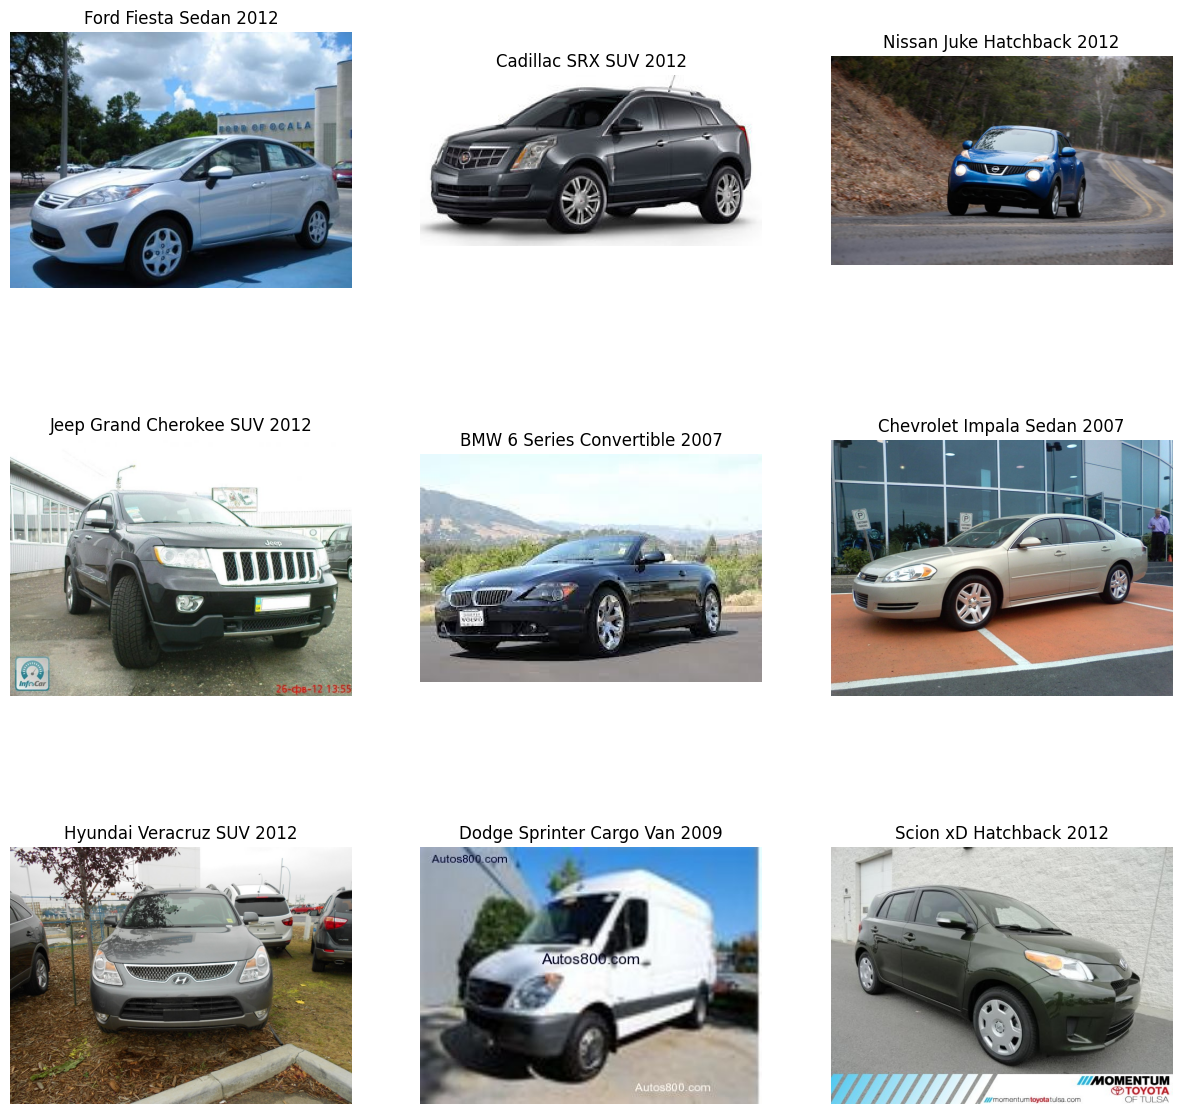

In [114]:
num_imgs = 9
cols = 3
rows = num_imgs // cols
fig, ax = plt.subplots(rows, cols, figsize = (15, 15))
for idx, im_idx in enumerate(random.sample([i for i in range(len(fname_to_class))], num_imgs)):
    filename, cl_id = list(fname_to_class.items())[im_idx]
    temp_image = cv2.imread(os.path.join(ADD_PATH, filename))
    temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB)
    ax[idx//cols][idx%cols].imshow(temp_image)
    ax[idx//cols][idx%cols].set_title(f'{id_to_car[cl_id]}')
    ax[idx//cols][idx%cols].axis('off')

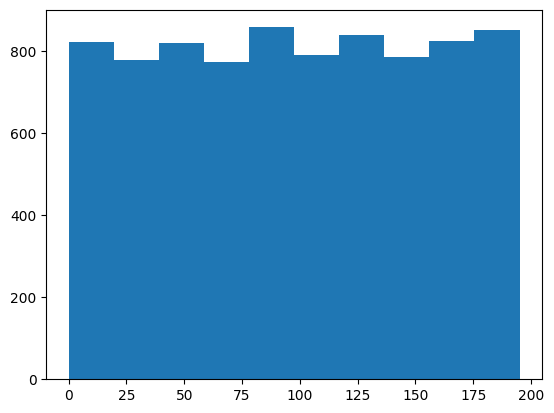

In [115]:
plt.hist(fname_to_class.values())
plt.show()

# Добавим аугментации

In [120]:
import torch
import torchvision
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
    
train_transforms = torchvision.transforms.Compose([
            torchvision.transforms.ToPILImage(), 
            torchvision.transforms.RandomRotation(15),
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.RandomVerticalFlip(),
            torchvision.transforms.Resize(
                size=(224, 224)
            ),
            torchvision.transforms.ToTensor(),  
            torchvision.transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
            ])
val_transforms =  torchvision.transforms.Compose([
            torchvision.transforms.ToPILImage(), 
            torchvision.transforms.Resize(
                size=(224, 224)
            ),
            torchvision.transforms.ToTensor(),  
            torchvision.transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
            ])

class CropClassifDataset(torch.utils.data.Dataset):
    def __init__(self, cars_items, transforms):
        self.cars = cars_items
        self.transforms = transforms
        
    def __len__(self):
        return len(self.cars)

    def __getitem__(self, idx):
        filename, cl_id = self.cars[idx]
        image = cv2.imread(os.path.join(ADD_PATH, filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transforms:
            image = self.transforms(image)
        sample = {'image': image, 'label': cl_id}
        return sample

In [121]:
items = list(fname_to_class.items())
random.shuffle(items)
train_items = items[:int(len(items) * 0.8)]
val_items = items[int(len(items) * 0.8):]

train_dataset = CropClassifDataset(train_items, train_transforms)
val_dataset = CropClassifDataset(val_items, val_transforms)


In [122]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, collate_fn=None, pin_memory=True, drop_last = True)
valid_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, collate_fn=None, pin_memory=True)

# Посмотрим на аугментированный датасет

In [123]:
batch = next(iter(train_loader))

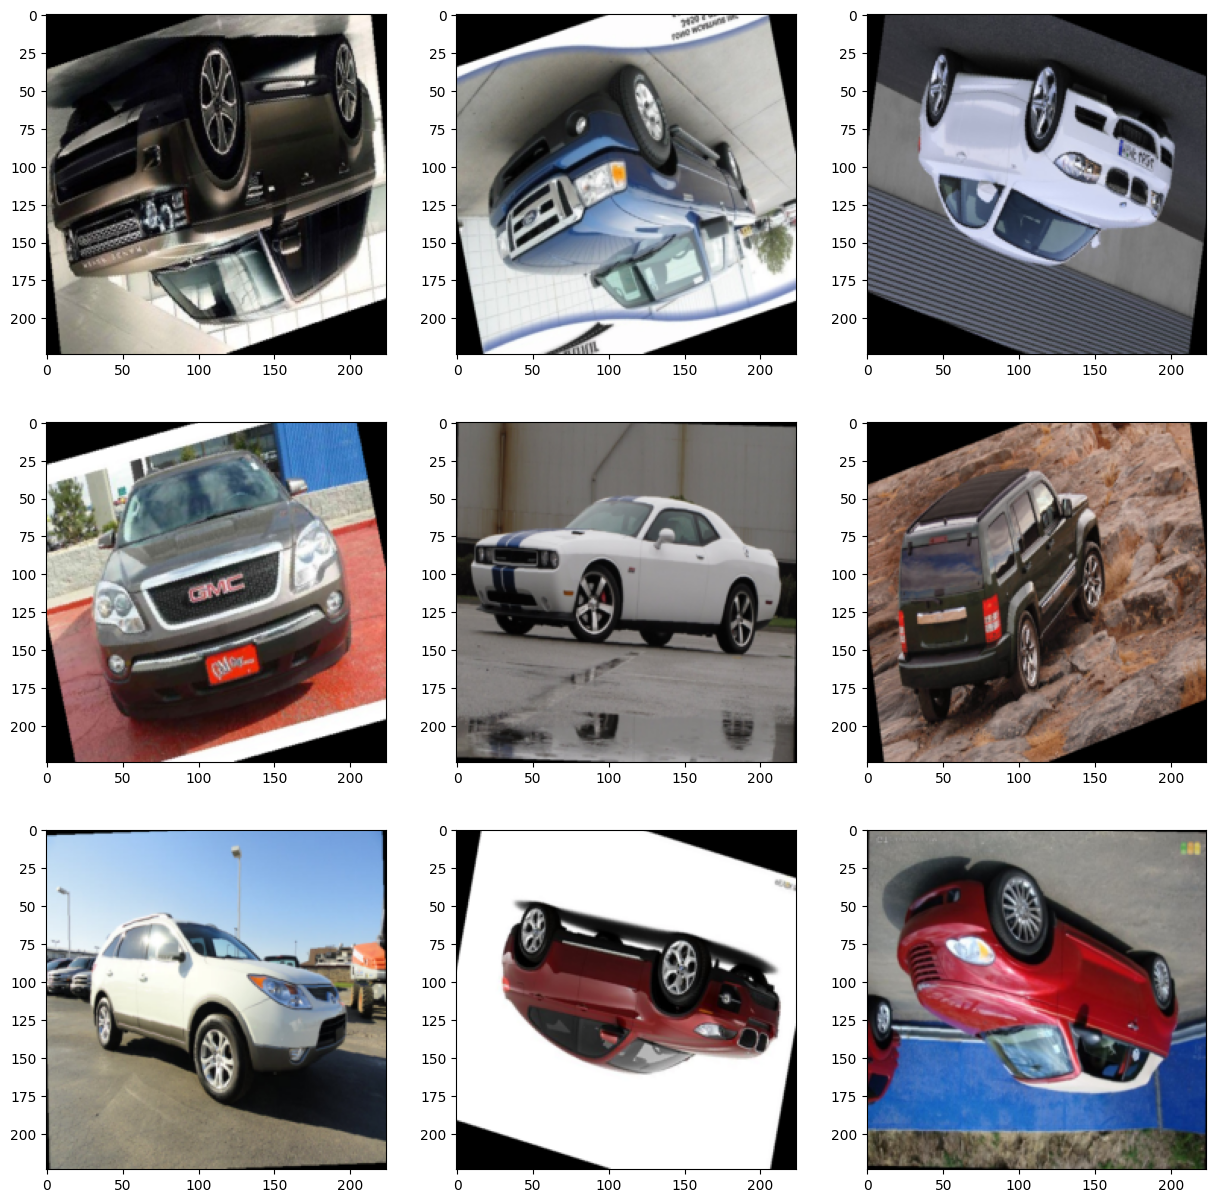

In [124]:
mean=[0.485, 0.456, 0.406],
std=[0.229, 0.224, 0.225]

num_imgs = 9
cols = 3
rows = num_imgs // cols
fig, ax = plt.subplots(rows, cols, figsize = (15, 15))

for i in range(num_imgs):
    img_tensor = batch['image'][i]
    z = img_tensor * torch.tensor(std).view(3, 1, 1)
    z = z + torch.tensor(mean).view(3, 1, 1)
    img = torchvision.transforms.ToPILImage(mode='RGB')(z)
    ax[i//cols][i%cols].imshow(img)

In [125]:
import torch
import torch.nn as nn

class CenterLoss(nn.Module):
    """Center loss.
    
    Reference:
    Wen et al. A Discriminative Feature Learning Approach for Deep Face Recognition. ECCV 2016.
    
    Args:
        num_classes (int): number of classes.
        feat_dim (int): feature dimension.
    """
    def __init__(self, num_classes=10, feat_dim=2, device='cpu'):
        super(CenterLoss, self).__init__()
        self.num_classes = num_classes
        self.feat_dim = feat_dim
        
        self.centers = nn.Parameter(torch.randn(self.num_classes, self.feat_dim))


    def forward(self, x, labels):
        """
        Args:
            x: feature matrix with shape (batch_size, feat_dim).
            labels: ground truth labels with shape (batch_size).
        """
        self.centers = self.centers.to(device)
        batch_size = x.size(0)
        distmat = torch.pow(x, 2).sum(dim=1, keepdim=True).expand(batch_size, self.num_classes) + \
                  torch.pow(self.centers, 2).sum(dim=1, keepdim=True).expand(self.num_classes, batch_size).t()
        distmat.addmm_(1, -2, x, self.centers.t())

        classes = torch.arange(self.num_classes).long()
        classes = classes.to(device)
        labels = labels.unsqueeze(1).expand(batch_size, self.num_classes)
        mask = labels.eq(classes.expand(batch_size, self.num_classes))

        dist = distmat * mask.float()
        loss = dist.clamp(min=1e-12, max=1e+12).sum() / batch_size

        return loss

# Реализуем Triplet Loss

In [135]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin
        
    def calc_euclidean(self, x1, x2):
        return torch.sum((x1 - x2)**2)
    
    def __forward(self, anchor, positive, negative):
        """For one element"""
        distance_positive = self.calc_euclidean(anchor, positive)
        distance_negative = self.calc_euclidean(anchor, negative)
        print("DIST: ", distance_positive, distance_negative)
        loss = torch.relu(distance_positive - distance_negative + self.margin)
        print("LOSS: ", loss)

        return loss
    
    def forward(self, x: torch.Tensor, labels: torch.Tensor):
        """For batch"""
#         x, labels = x.cuda(), labels.cuda()
        loss = []
        for i in range(len(x)):
            prediction = x[i]
            correct_class = labels[i]
            
            same_class = (labels == labels[i])
            positives = []
            negatives = []
            
            for j in range(len(x)):
                if same_class[j] and j != i:
                    positives.append(j)
                else:
                    negatives.append(j)
            
            if len(positives) == 0 or len(negatives) == 0:
                continue
                
            print("POS:", positives)
            print("NEG:", negatives)
            positive_idx = random.choice(positives)
            negative_idx = random.choice(negatives)
            
            loss.append(max(self.__forward(prediction, x[positive_idx], x[negative_idx]), 0))
        print(loss)
        return sum(loss) / len(loss)

# Проверка вычислений

In [136]:
batch = next(iter(train_loader))

In [137]:
loss = TripletLoss()

In [138]:
images = batch['image']
labels = batch['label'].to(torch.long)
images, labels = images.cuda(), labels.cuda()

In [139]:

preds = pl_model.model(images)

In [140]:
res = loss.forward(preds, labels)

POS: [32]
NEG: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]
DIST:  tensor(6994.2993, device='cuda:0', grad_fn=<SumBackward0>) tensor(6552.0156, device='cuda:0', grad_fn=<SumBackward0>)
LOSS:  tensor(443.2837, device='cuda:0', grad_fn=<ReluBackward0>)
POS: [30]
NEG: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]
DIST:  tensor(6780.6562, device='cuda:0', grad_fn=<SumBackward0>) tensor(8491.5889, device='cuda:0', grad_fn=<SumBackward0>)
LOSS:  tensor(0., device='cuda:0', grad_fn=<ReluBackward0>)
POS: [34]
NEG: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25

In [141]:
res

tensor(738.6937, device='cuda:0', grad_fn=<DivBackward0>)

In [142]:
# !pip install pytorch-lightning pytorch_metric_learning

# Arcface
## Вместо ResNet50 я возьму, как и в прошлый раз, MobileNet, так как она считается наиболее быстро

In [143]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import LearningRateMonitor
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights
from pytorch_metric_learning import losses

class CarEmbedder(pl.LightningModule):
    def __init__(self, class_dict, learning_rate, emb_size):
        super().__init__()
        self.learning_rate = learning_rate
        self.model = mobilenet_v3_small(weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1)
        
        self.model.fc = torch.nn.Sequential(
                            torch.nn.Linear(in_features=2048, out_features=emb_size))
        self.classifier_head = torch.nn.Sequential(
                            torch.nn.ReLU(),
                            torch.nn.Linear(in_features=emb_size, out_features=len(class_dict)))
        self.arc_face_loss = losses.ArcFaceLoss(len(class_dict), emb_size, margin=28.6, scale=64)
        self.classif_loss = torch.nn.CrossEntropyLoss()
#         self.center_loss = CenterLoss(len(class_dict), emb_size, device)
        self.triplet_loss = TripletLoss()
        self.alpha = 0.4

        self.save_hyperparameters()

    def training_step(self, batch, batch_idx):
        images = batch['image']
        labels = batch['label'].to(torch.long)
        preds = self.model(images)
        

        # ArcFace
        
        # final_loss = self.arc_face_loss(preds, labels)
        

        # CE + CenterLoss
        
        triplet_loss = self.triplet_loss(preds, labels)
        preds = self.classifier_head(preds)
        classif_loss = self.classif_loss(preds, labels)
        final_loss = triplet_loss * self.alpha + classif_loss

        
        self.log("train_loss", final_loss, sync_dist=True)
        return final_loss
    
    def validation_step(self, batch, batch_idx):
        images = batch['image']
        labels = batch['label'].to(torch.long)
        preds = self.model(images)
        
        # ArcFace
        
        # final_loss = self.arc_face_loss(preds, labels)
        

        
        
        # CE + CenterLoss
        
        triplet_loss = self.triplet_loss(preds, labels)
        preds = self.classifier_head(preds)
        classif_loss = self.classif_loss(preds, labels)
        final_loss = triplet_loss * self.alpha + classif_loss
        
        self.log("validation_loss", final_loss, sync_dist=True)
        
    def forward(self, images):
        if len(images.shape) == 4:
            preds = self.model(images) 
        else:
            preds = self.model(images.unsqueeze(0))
        return preds
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return [optimizer]

In [144]:
# model
pl_model = CarEmbedder(id_to_car, 3e-4, 1000)
if torch.cuda.is_available():
    pl_model.cuda()
checkpoint_callback = ModelCheckpoint(monitor='validation_loss',mode='min',  save_top_k=3)
early_stopping = EarlyStopping(monitor="validation_loss", mode="min", patience=2)
lr_monitor = LearningRateMonitor(logging_interval='step')

# train model
trainer = pl.Trainer(max_epochs = 2, accelerator=device, devices = 1, callbacks=[checkpoint_callback, early_stopping, lr_monitor])

In [145]:
pl_model

CarEmbedder(
  (model): MobileNetV3(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
            (activation): ReLU()
            (scale_activation): Hardsigmoid()
          )
          (2): Conv2d

In [146]:
# !pip install tensorflow-tensorboard

In [147]:
# !pip install tensorboard

In [150]:
# pip install tensorboard --upgrade

  Obtaining dependency information for tensorboard from https://files.pythonhosted.org/packages/6e/0c/1059a6682cf2cc1fcc0d5327837b5672fe4f5574255fa5430d0a8ceb75e9/tensorboard-2.15.1-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 57.1 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 1.14.0
    Uninstalling tensorboard-1.14.0:
      Successfully uninstalled tensorboard-1.14.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.13.0 requires tensorboard<2.14,>=2.13, but you have tensorboard 2.15.1 which is incompatible.
tensorflowjs 4.13.0 requires packaging~=23.1, but you have packaging 21.3 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [158]:
%reload_ext tensorboard
%tensorboard --logdir lightning_logs

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Traceback (most recent call last):
  File "/opt/conda/bin/tensorboard", line 8, in <module>
    sys.exit(run_main())
  File "/opt/conda/lib/python3.10/site-packages/tensorboard/main.py", line 46, in run_main
    app.run(tensorboard.main, flags_parser=tensorboard.configure)
  File "/opt/conda/lib/python3.10/site-packages/absl/app.py", line 308, in run
    _run_main(main, args)
  File "/opt/conda/lib/python3.10/site-packages/absl/app.py", line 254, in _run_main
    sys.exit(main(a

In [ ]:
trainer.fit(model=pl_model, train_dataloaders=train_loader, 
            val_dataloaders=valid_loader)

In [ ]:
torch.save(pl_model.state_dict(), "model_weights.pth.tar")


In [161]:
pl_model.load_state_dict(torch.load('/kaggle/working/model_weights.pth.tar'))

<All keys matched successfully>

# Tensorboard отказался загружаться(
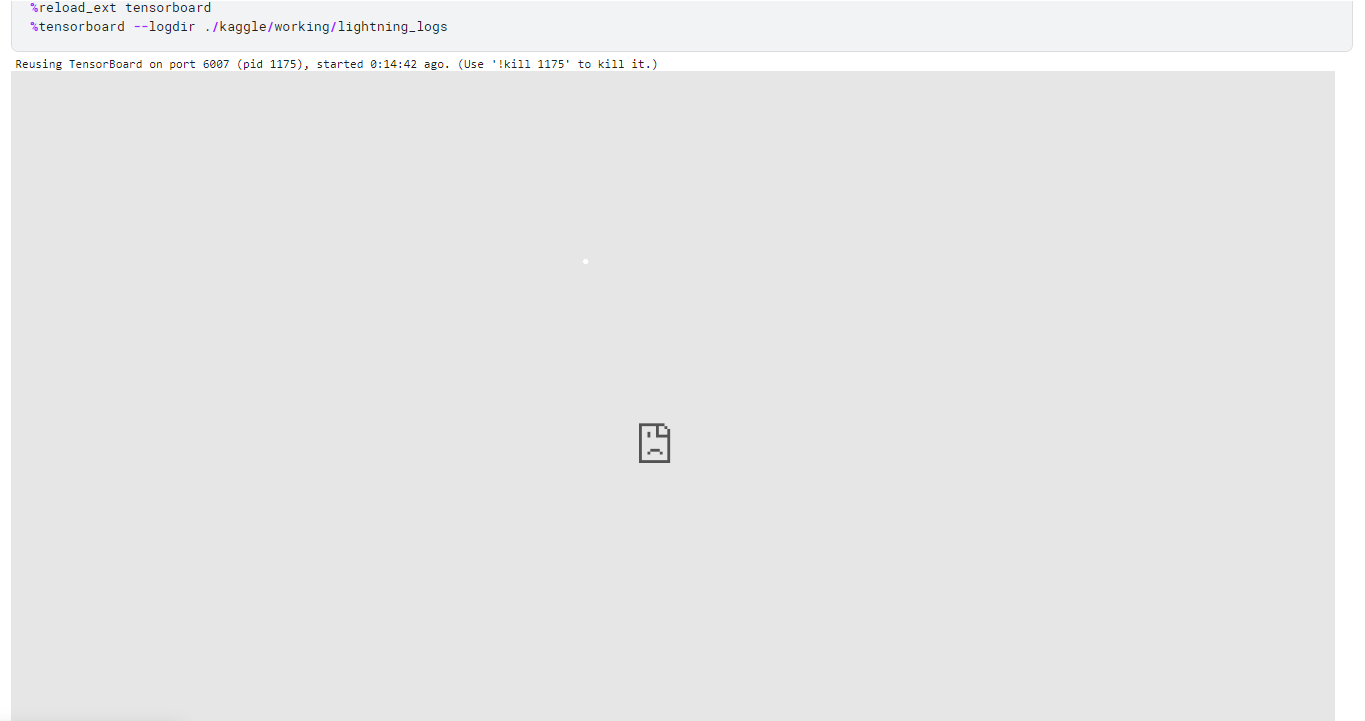

# Поэтому просто посмотрим на результаты модели после 20 эпох

In [162]:
# !pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 59.4 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.8-py3-none-any.whl size=38243 sha256=1ffafcb414cd0713a5bdccbeb7a1cb03c6c84b5725adaeaed38bd3f21c176565
  Stored in directory: /root/.cache/pip/wheels/f8/04/36/94ff3c8a4215826a21946b34c01180817e606989fdf53f7cd6
Successfully built grad-cam


In [163]:
from PIL import Image
import requests
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

transform_to_show = torchvision.transforms.Compose([
                        torchvision.transforms.ToPILImage(), 
                        torchvision.transforms.Resize(
                            size=(224, 224)
                        ),
                        torchvision.transforms.ToTensor()
                        ])

def get_image_from_path(path):
    """A function that gets a path to an image, 
    and returns a numpy image and a preprocessed
    torch tensor ready to pass to the model """

    orig_im = np.array(Image.open(path).convert('RGB'))
    rgb_im = np.array(transform_to_show(orig_im).permute(1,2,0))
    transformed_im = val_transforms(orig_im).unsqueeze(0).to(device)
    orig_im = cv2.resize(orig_im, (512, 512))

    return orig_im, rgb_im, transformed_im

In [178]:
transform_to_show = torchvision.transforms.Compose([
                        torchvision.transforms.ToPILImage(), 
                        torchvision.transforms.Resize(
                            size=(224, 224)
                        ),
                        torchvision.transforms.ToTensor()
                        ])

def show_grad_cam(model, num_imgs):
    model.eval()
    cols = 3
    rows = num_imgs // cols
    fig, ax = plt.subplots(rows, cols, figsize = (15, 15))
    for idx, im_idx in enumerate(random.sample([i for i in range(len(fname_to_class))], num_imgs)):
        filename, cl_id = list(fname_to_class.items())[im_idx]
        temp_image = cv2.imread(os.path.join(ADD_PATH, filename))
        temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB)
        rgb_im = np.array(transform_to_show(temp_image).permute(1,2,0))
        transformed_im = val_transforms(temp_image).unsqueeze(0).to(device)
        target_layers = [model.features[12]] # нужен слой, предшествующий avgpool
        cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
        grayscale_cam = cam(input_tensor=transformed_im)
        grayscale_cam = grayscale_cam[0, :]
        visualization = show_cam_on_image(rgb_im, grayscale_cam, use_rgb=True)
        pred = id_to_car[model(transformed_im).argmax().item()]
        ax[idx//cols][idx%cols].imshow(visualization)
        ax[idx//cols][idx%cols].set_title(f'gt : {id_to_car[cl_id]} \n pred: {pred}')
        ax[idx//cols][idx%cols].axis('off')


def show_diff_grad_methods(model, methods):
    model.eval()
    num_imgs = 4
    rows = len(methods)
    fig, ax = plt.subplots(rows, num_imgs, figsize = (30, 30))
    random_images = random.sample([i for i in range(len(fname_to_class))], num_imgs)
    for row_id, method in enumerate(methods):
        for col_id, im_idx in enumerate(random_images):
            filename, cl_id = list(fname_to_class.items())[im_idx]
            temp_image = cv2.imread(os.path.join(ADD_PATH, filename))
            temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB)
            rgb_im = np.array(transform_to_show(temp_image).permute(1,2,0))
            transformed_im = val_transforms(temp_image).unsqueeze(0).to(device)
            target_layers = [model.features[12]]
            cam = method(model=model, target_layers=target_layers, use_cuda=True)
            grayscale_cam = cam(input_tensor=transformed_im)
            grayscale_cam = grayscale_cam[0, :]
            visualization = show_cam_on_image(rgb_im, grayscale_cam, use_rgb=True)
            ax[row_id][col_id].imshow(visualization)
            ax[row_id][col_id].set_title(f"method : {str(method).split('.')[-1][:-2]} \n gt : {id_to_car[cl_id]}")
            ax[row_id][col_id].axis('off')


In [179]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import numpy as np


100%|██████████| 36/36 [00:00<00:00, 110.18it/s]

100%|██████████| 36/36 [00:00<00:00, 129.54it/s]

100%|██████████| 36/36 [00:00<00:00, 129.49it/s]

100%|██████████| 36/36 [00:00<00:00, 132.30it/s]

100%|██████████| 18/18 [00:00<00:00, 75.88it/s]

100%|██████████| 18/18 [00:00<00:00, 92.84it/s]

100%|██████████| 18/18 [00:00<00:00, 91.14it/s]

100%|██████████| 18/18 [00:00<00:00, 92.90it/s]


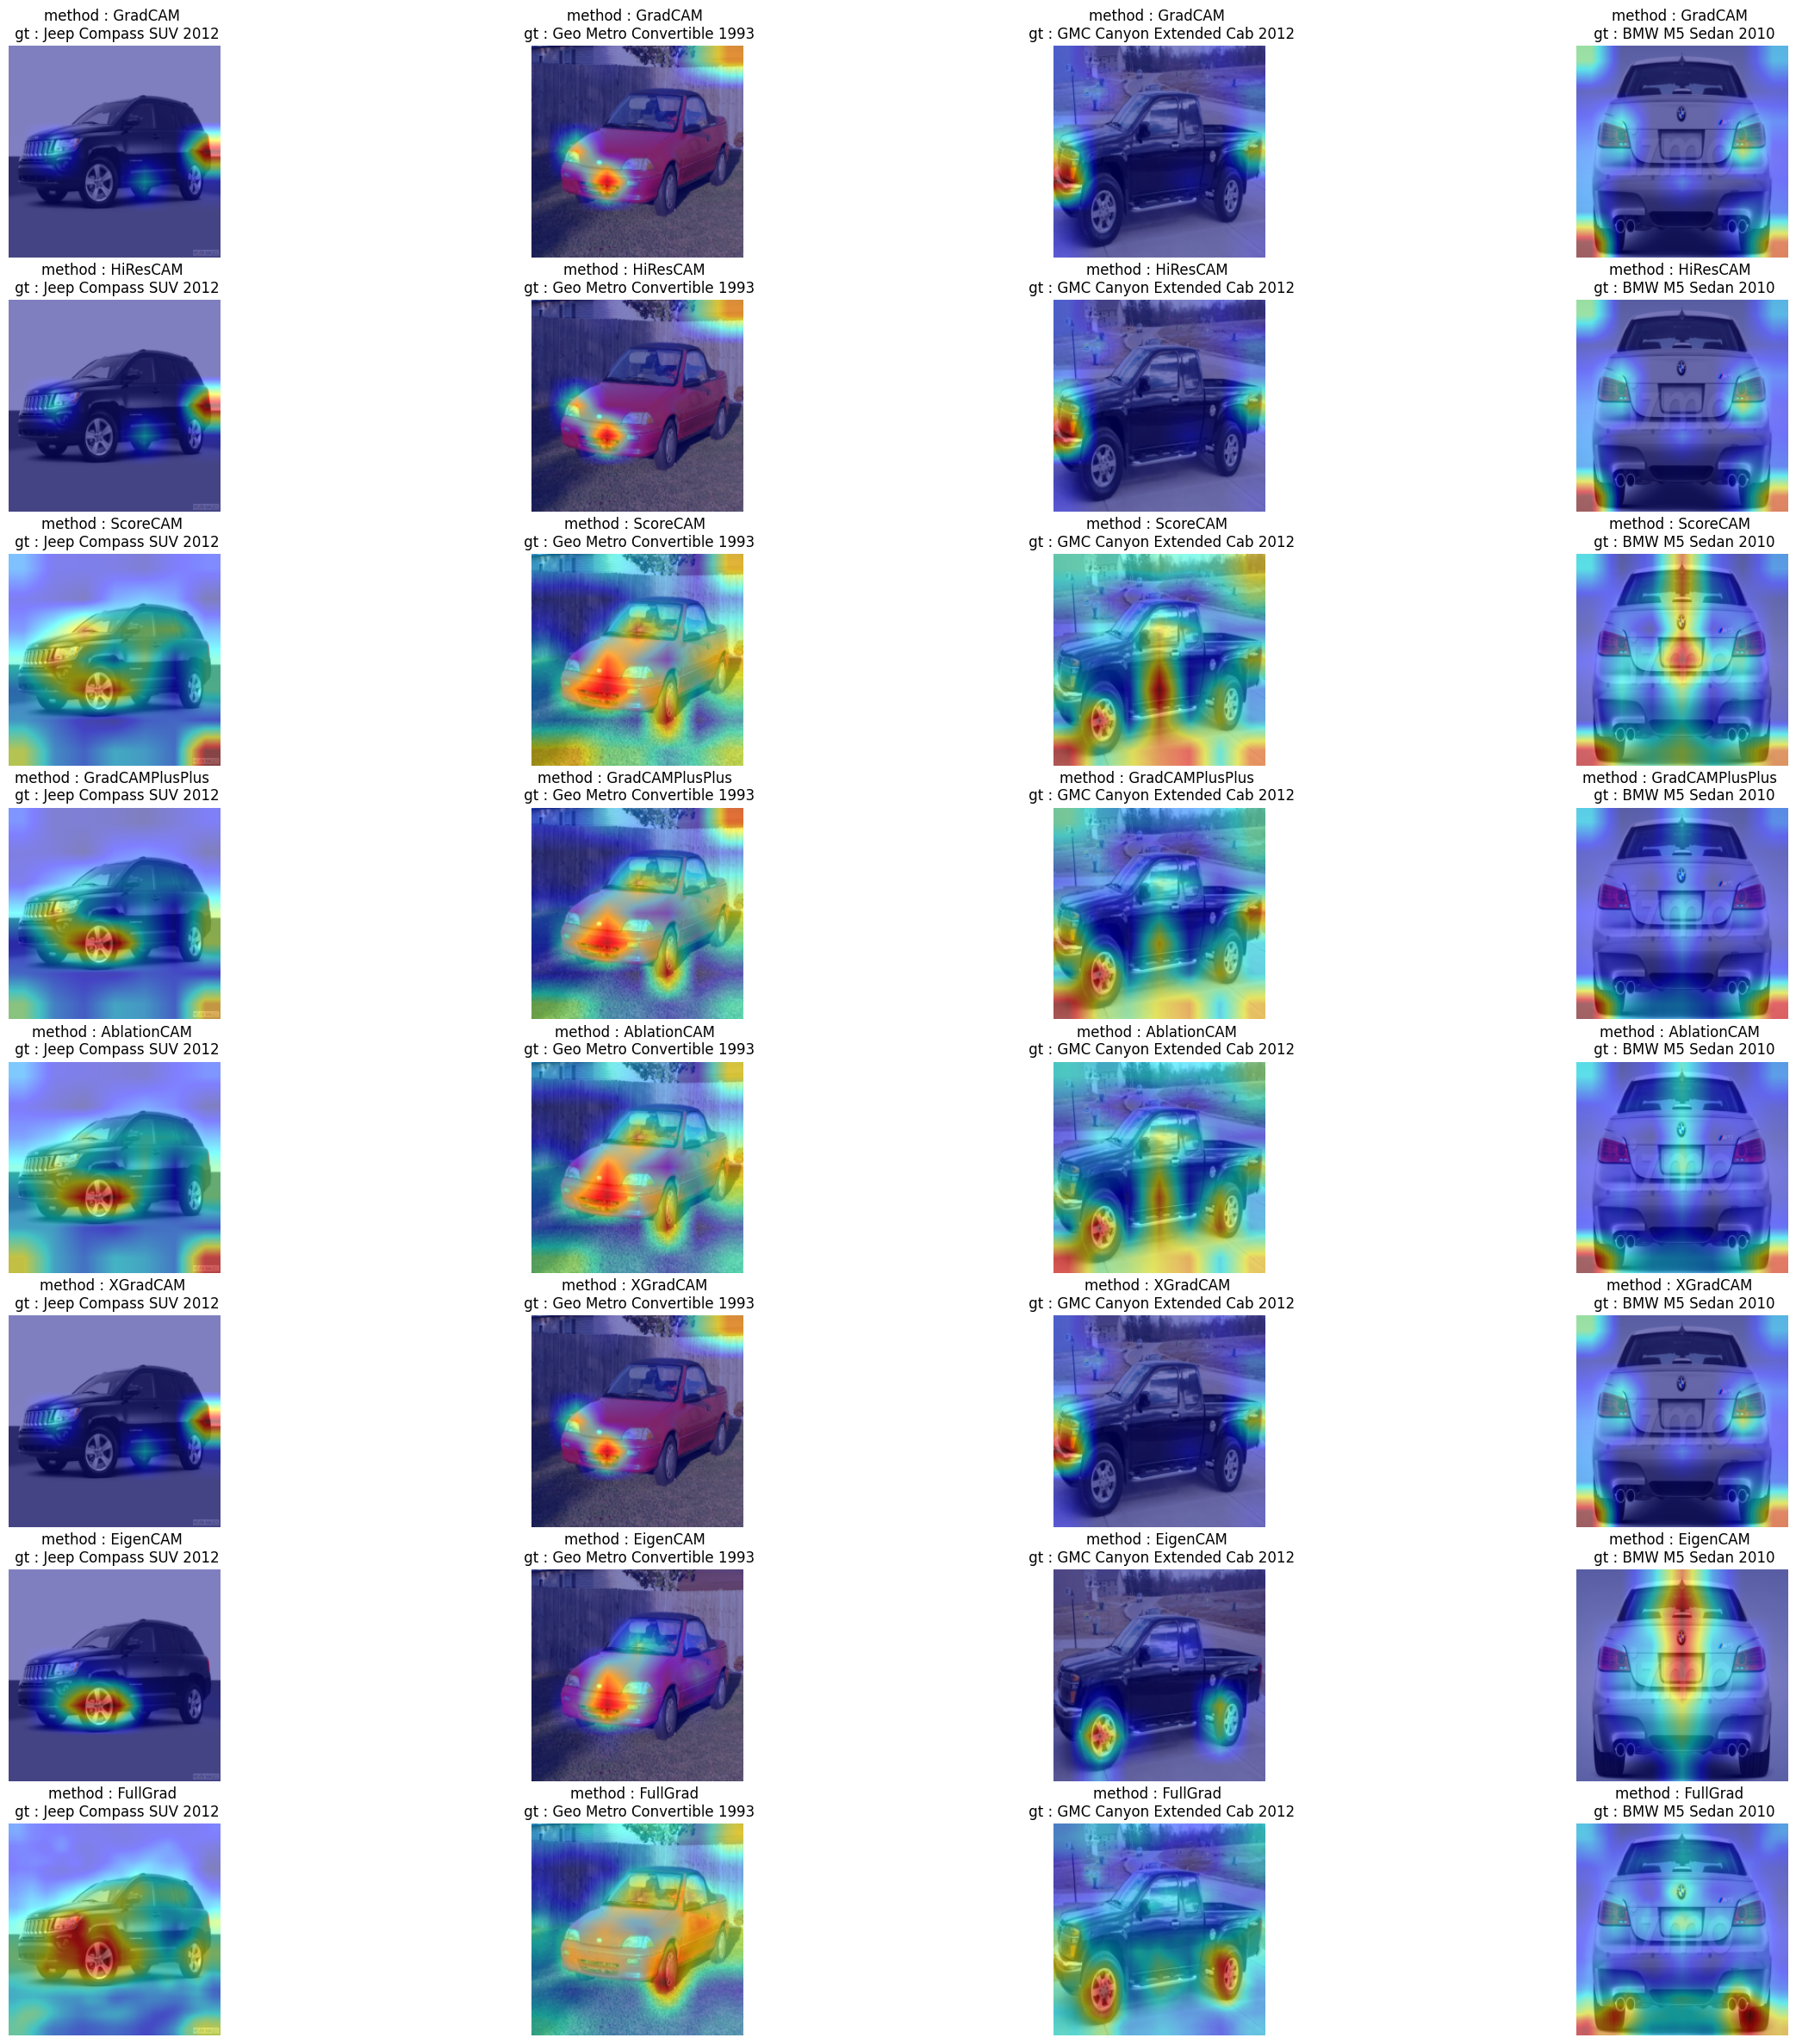

In [180]:
show_diff_grad_methods(pl_model.model, [ GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad])

# Видно, что некоторые методы обучились существенно лучше, чем другие

# Метрики